# Initialization

In [ ]:
from transformers import MBartTokenizer, MBartForConditionalGeneration
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from optimum.bettertransformer import BetterTransformer
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import torch
from tqdm import tqdm

import pandas as pd
import numpy as np
import random
import os


import re
from preprocessing import clean_text

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/PROJECTS_COMPETITIONS/news_classification/data/train_data.csv").drop(columns = ['Unnamed: 0'])
df_test = pd.read_csv("/content/drive/MyDrive/PROJECTS_COMPETITIONS/news_classification/data/test_data.csv").drop(columns = ['Unnamed: 0'])

In [ ]:
df_test_preprocessed = pd.read_csv("/content/drive/MyDrive/PROJECTS_COMPETITIONS/news_classification/data/test_summarized_data.csv").drop(columns = ['Unnamed: 0'])

# EDA and data preprocessing



## Nan processing

In [ ]:
# проверим наны
df_train.isna().sum()

sentence    0
label       0
dtype: int64

In [ ]:
df_test.isna().sum()
# присутствуют дубликаты - будем иметь в виду (я случайно перезапустил ячейку)

id         0
title    207
text       2
dtype: int64

In [ ]:
# вот это поворот:
df_test[df_test.title.isna() & df_test.text.isna()]

,id,title,text
1874,"Мировые цены на нефть в понедельник, 2 декабря...",NaN,NaN


In [ ]:
# такой случай один
df_test[df_test.id.apply(lambda x: len(x)) > 5]

,id,title,text
1874,"Мировые цены на нефть в понедельник, 2 декабря...",NaN,NaN


In [ ]:
df_test.iloc[1875]

id                                                       1874
title                                           Шашечки и мат
text        koment@sobesednik.ru На начало декабря намечен...
sentence    Шашечки и мат koment На начало декабря намечен...
Name: 1875, dtype: object

In [ ]:
# фиксим
df_test.iloc[1874].text = df_test.iloc[1874].id
df_test.fillna('', inplace = True)

In [ ]:
# конкатенируем заголовки и тексты
df_test['sentence'] = ((df_test.title + ' ') + df_test.text)

## Naive removal of duplicates

In [ ]:
# проверим, есть ли дубликаты
df_train.sentence.duplicated().sum()

56

In [ ]:
# проверим, есть ли дубликаты с разными метками
df_train.groupby(by = 'sentence').label.count().mean()

1.0347179169249845

In [ ]:
# найдем их
grouped = df_train.groupby(by = 'sentence').label.nunique().reset_index()
grouped[grouped.label > 1].iloc[0].sentence

'Они заключили договор с компанией «АртСтройТехно» о строительстве там домов, однако с 2003 года обманутые «Спасовцы» так и не могут получить свое жилье.'

In [ ]:
# удалим их
df_train.drop(index = df_train[df_train.sentence == grouped[grouped.label > 1].iloc[0].sentence].index, inplace = True)

In [ ]:
# дедублицируем оставшиеся предложения
df_train = df_train.drop_duplicates(subset = 'sentence')
df_train.sentence.duplicated().sum()

0

## Test texts cleaning

In [ ]:
df_test['sentence'] = df_test.sentence.apply(clean_text)

## Analysis of the distribution of the number of words

<ipython-input-16-548fba511233>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_train.sentence.apply(lambda x: len(str(x).split())), bins = 100, palette = 'Set1', alpha = 0.8)


Text(0, 0.5, 'Количество предложений')

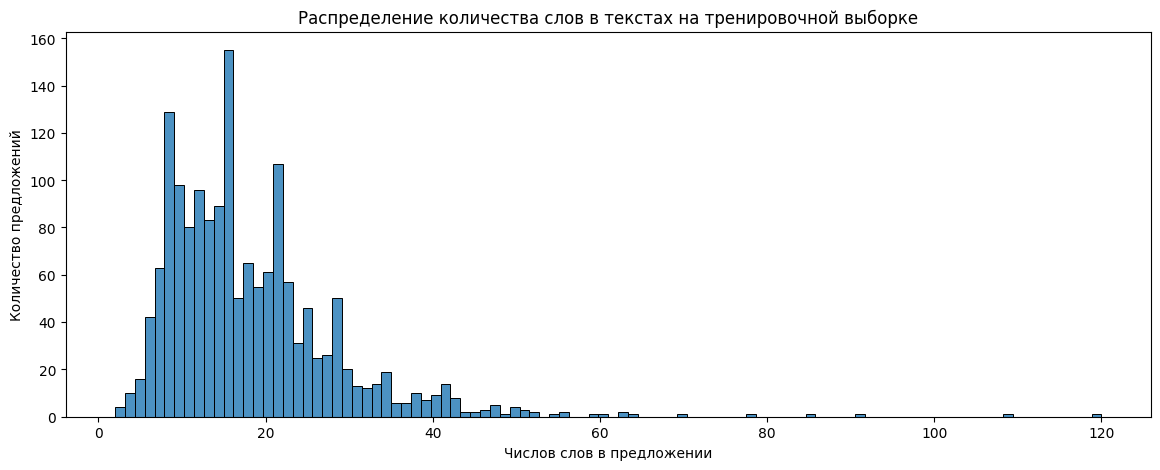

In [ ]:
plt.figure(figsize = (14,5))
sns.histplot(df_train.sentence.apply(lambda x: len(str(x).split())), bins = 100, palette = 'Set1', alpha = 0.8)
plt.title('Распределение количества слов в текстах на тренировочной выборке')
plt.xlabel('Числов слов в предложении')
plt.ylabel('Количество предложений')

<ipython-input-17-23b04c8167c5>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_test.sentence.apply(lambda x: len(str(x).split())), bins = 100, palette = 'Set1', alpha = 0.8)


Text(0, 0.5, 'Количество предложений')

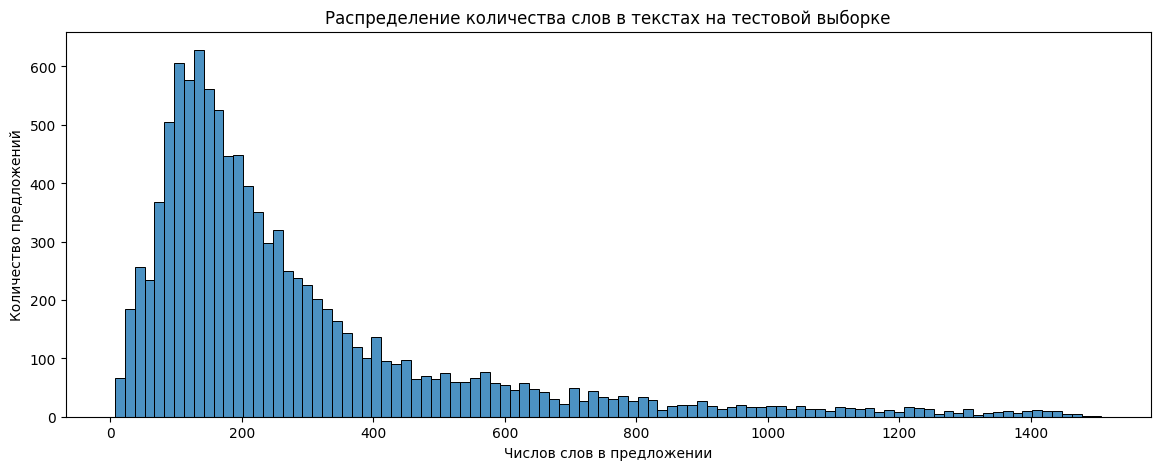

In [ ]:
plt.figure(figsize = (14,5))
sns.histplot(df_test.sentence.apply(lambda x: len(str(x).split())), bins = 100, palette = 'Set1', alpha = 0.8)
plt.title('Распределение количества слов в текстах на тестовой выборке')
plt.xlabel('Числов слов в предложении')
plt.ylabel('Количество предложений')

Mean number of words per sentence in test data is 10 times larger than train. It's obviously, that we have to summarize text from text before put them in model 

## Large texts summarizing 

For texts with more than 512 tokens, we will summarize them to fit into the classifier. Below is the summarizer code

### Choosing a method: extractive vs abstractive summarization
I decided to use the abstractive model, despite the fact that extractive models work faster in this case. My choice is justified by the fact that the texts in the test set are quite large, there may be several different topics, and an extractive model may not extract what we need from such text.

### Model selection 

I chose the model [mbart_ru_sum_gazeta](https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta) because it is trained for summarizing news in Russian and adapted to the domain of our data. Additionally, in the model author's article about the training dataset, you can see that the distribution of the number of tokens per sentence in the test set and the model's output is suitable for our task. [arxiv:2006.11063](https://arxiv.org/pdf/2006.11063.pdf)



In [ ]:
from models.summarization import * 

In [ ]:
import torch, gc
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
test_loader = DataLoader(df_test.sentence, batch_size=24, shuffle=False, pin_memory=True)

In [ ]:
summarized = get_summary(test_loader)

In [ ]:
df_test['summary'] = np.array(summarized)
df_test.to_csv('/content/drive/MyDrive/PROJECTS_COMPETITIONS/news_classification/data/test_summarized_data.csv')

In [ ]:
df_test.summary

0        В соответствии с постановлением Правительства ...
1        На Белорусско-Савеловском центральном диаметре...
2        Начато расследование дела о крушении самолета ...
3        С Днем юриста поздравляем сотрудников и препод...
4        В Костроме прошел межрегиональный форум, посвя...
                               ...                        
10566    Сборная России по гандболу одержала третью поб...
10567    В МГУ я училась в институте. В одном из универ...
10568    Футбольный клуб «Ростов» оскорбил спонсора из-...
10569    Министр здравоохранения РК Елжан Биртанов расс...
10570    Мэрия Красноярска возглавила Палату городов це...
Name: summary, Length: 10571, dtype: object

<ipython-input-227-b61068ab3927>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_test.summary.apply(lambda x: len(str(x).split())), bins = 60, palette = 'Set1', alpha = 0.8)


Text(0, 0.5, 'Количество предложений')

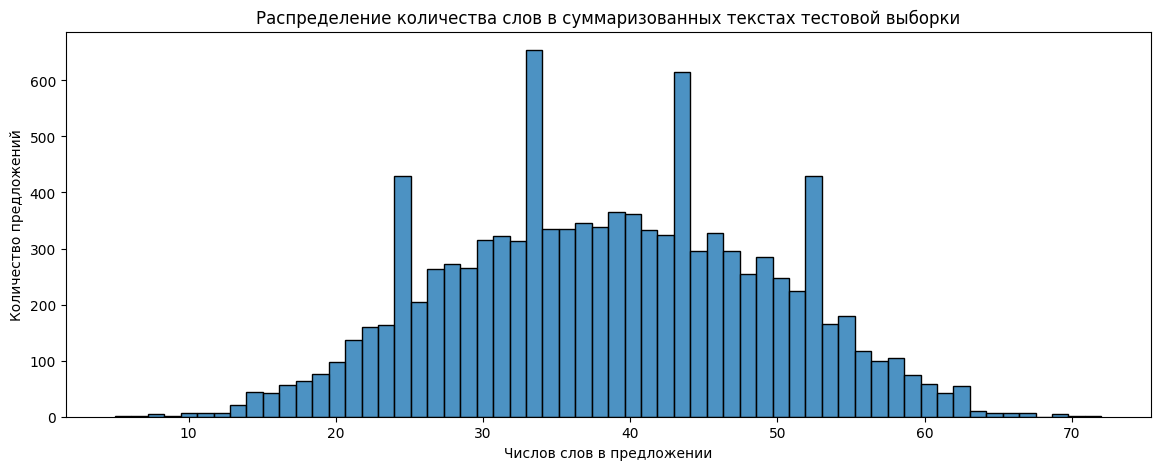

In [ ]:
plt.figure(figsize = (14,5))
sns.histplot(df_test.summary.apply(lambda x: len(str(x).split())), bins = 60, palette = 'Set1', alpha = 0.8)
plt.title('Распределение количества слов в суммаризованных текстах тестовой выборки')
plt.xlabel('Числов слов в предложении')
plt.ylabel('Количество предложений')

As seen, on average, the number of words in the summaries is around 40, while in the training set, this number is less than 20. When I was reading the article, I thought that the average on the training set was around 40, so I ended up making a mistake. Ideally, for summarization, it would be better to use a different model that is trained to generate summaries with a specified number of tokens. At the point of generating the summary for the test set, sample the number of tokens from the distribution in the training set to feed into the model.

### Sampling from distribution of the number of words

In [ ]:
import scipy.stats as ss
from scipy.special import softmax
import matplotlib.pyplot as plt

In [ ]:
train_distr = df_train.sentence.apply(lambda x: len(str(x).split())).value_counts().reset_index()

In [ ]:
t = 0.029
values = train_distr['index'].values.tolist()[:-2]
probs = softmax(t*train_distr['sentence'].values[:-2]).tolist()
distr = ss.rv_discrete(values=(values, probs))

<ipython-input-39-c6f9f8de1012>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(distr.rvs(size=(1, n), random_state = random_state).tolist()[0], bins = 100, palette = 'Set1', alpha = 0.8, ax =axs[0])
<ipython-input-39-c6f9f8de1012>:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_train.sentence.apply(lambda x: len(str(x).split())), bins = 100, palette = 'Set1', alpha = 0.8,ax =axs[1])


Text(0, 0.5, 'Количество предложений')

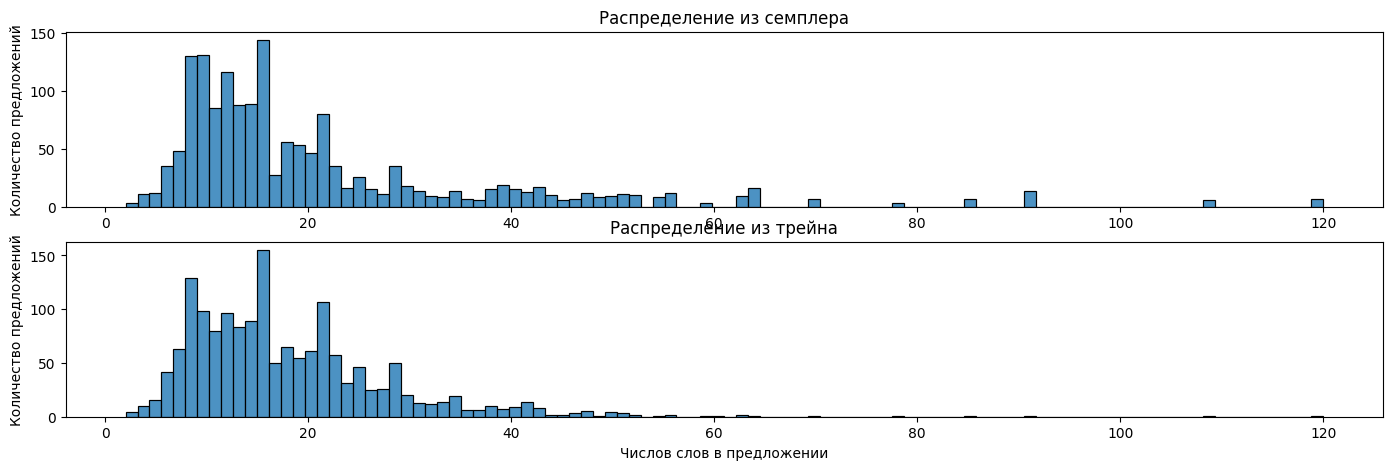

In [ ]:
n = df_train.shape[0]

fig, axs = plt.subplots(figsize = (17,5), nrows=2)
sns.histplot(distr.rvs(size=(1, n), random_state = random_state).tolist()[0], bins = 100, palette = 'Set1', alpha = 0.8, ax =axs[0])

axs[0].set_title('Распределение из семплера')
axs[0].set_ylabel('Количество предложений')

# для сравнения
sns.histplot(df_train.sentence.apply(lambda x: len(str(x).split())), bins = 100, palette = 'Set1', alpha = 0.8,ax =axs[1])
axs[1].set_title('Распределение из трейна')
axs[1].set_xlabel('Числов слов в предложении')
axs[1].set_ylabel('Количество предложений')

<ipython-input-40-61f4799e9b34>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(test_words_distr, bins = 100, palette = 'Set1', alpha = 0.8)


Text(0, 0.5, 'Количество предложений')

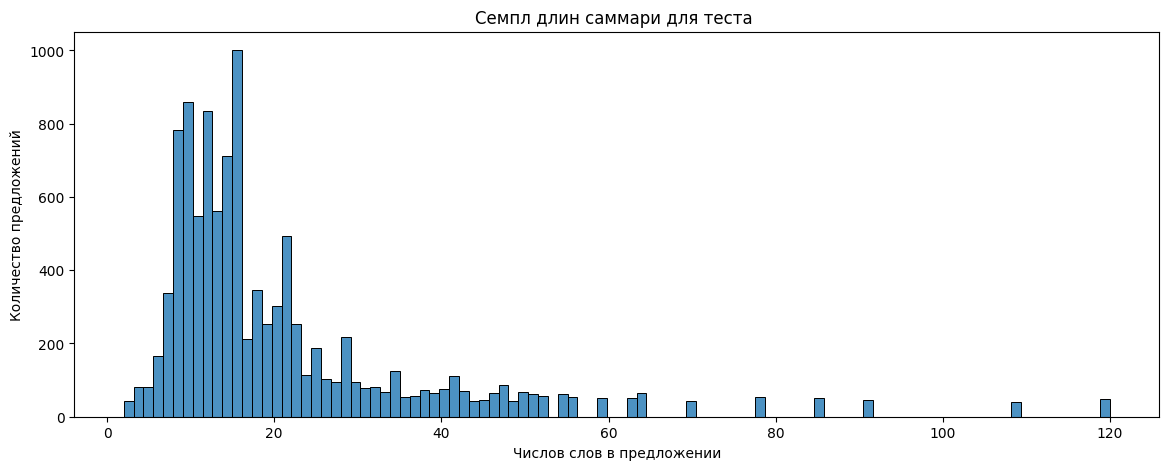

In [ ]:
n = df_test.shape[0]
test_words_distr = distr.rvs(size=(1, n), random_state = random_state).tolist()[0]

plt.figure(figsize = (14,5))
sns.histplot(test_words_distr, bins = 100, palette = 'Set1', alpha = 0.8)
plt.title('Семпл длин саммари для теста ')
plt.xlabel('Числов слов в предложении')
plt.ylabel('Количество предложений')

## Summarization model 2 

In [ ]:
from models.summarization_2 import summarize as summarize_2

test_sentences = '[' + pd.DataFrame(np.sort(np.array(test_words_distr))[::-1])[0].astype(str) + '] ' + df_test.sort_values(by="sentence", key=lambda x: x.str.len(), ascending=[0]).reset_index(drop = True).sentence
test_sorted_loader = DataLoader(test_sentences, batch_size=8, shuffle=False, pin_memory=True)

In [ ]:
summarized = summarize_2(test_sorted_loader, test_words_distr)

In [ ]:
# кривой код, написанный на скорую руку

df_test.iloc[df_test.sort_values(by="sentence", key=lambda x: x.str.len(), ascending=[0]).index]['summary'] = np.array(summarized)
indexes = df_test.sort_values(by="sentence", key=lambda x: x.str.len(), ascending=[0]).index

df_test = df_test.iloc[indexes]
df_test['summary'] = np.array(summarized)
df_test.sort_index(inplace = True)
df_test.to_csv('/content/drive/MyDrive/PROJECTS_COMPETITIONS/news_classification/data/test_summarized_data_2.csv')

<ipython-input-140-b1c5b34bed75>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_test.summary.apply(lambda x: len(str(x).split())), bins = 80, palette = 'Set1', alpha = 0.8)


Text(0, 0.5, 'Количество предложений')

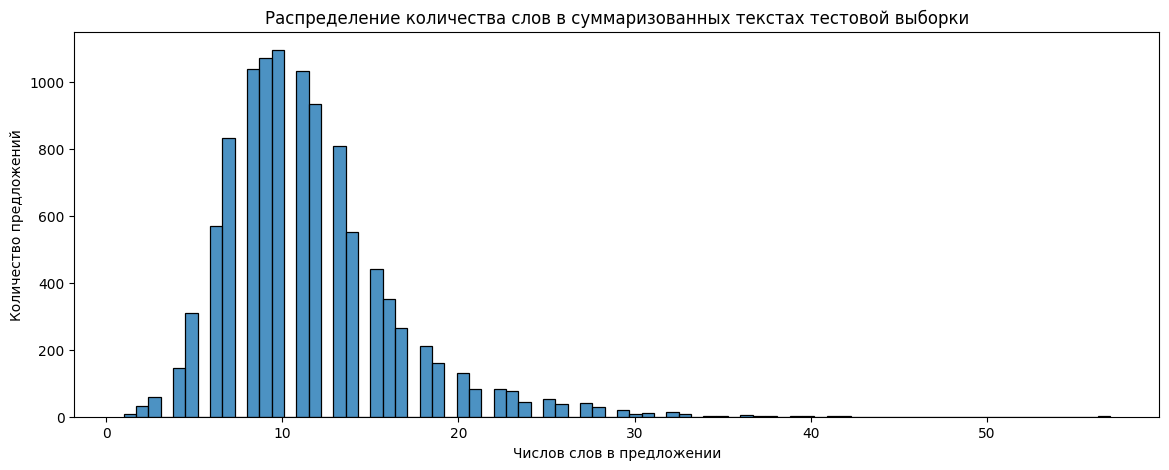

In [ ]:
plt.figure(figsize = (14,5))
sns.histplot(df_test.summary.apply(lambda x: len(str(x).split())), bins = 80, palette = 'Set1', alpha = 0.8)
plt.title('Распределение количества слов в суммаризованных текстах тестовой выборки')
plt.xlabel('Числов слов в предложении')
plt.ylabel('Количество предложений')

Now it has improved, but the quality of the summaries has deteriorated significantly, so in the end, I decided to stick with the first model

## Word distribution analysis

In [ ]:
!pip install natasha -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 31.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    Doc
)
import nltk

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from preprocessing import preprocessDataset

In [ ]:
preprocessDataset(df_train.iloc[0].sentence)

'срыв срок строительство зоопарк оценить млрд рубль управление капстроительство намерен взыскать арбитраж млрд руб ао рждстрой качество неустойка срыв срок сдача первый очередь зоопарк'

In [ ]:
preprocessed_texts = []

for text in tqdm(df_train.sentence):
    preprocessed_texts.append(preprocessDataset(text))

100%|██████████| 1612/1612 [00:27<00:00, 57.74it/s]


In [ ]:
train_texts = ' '.join(preprocessed_texts)

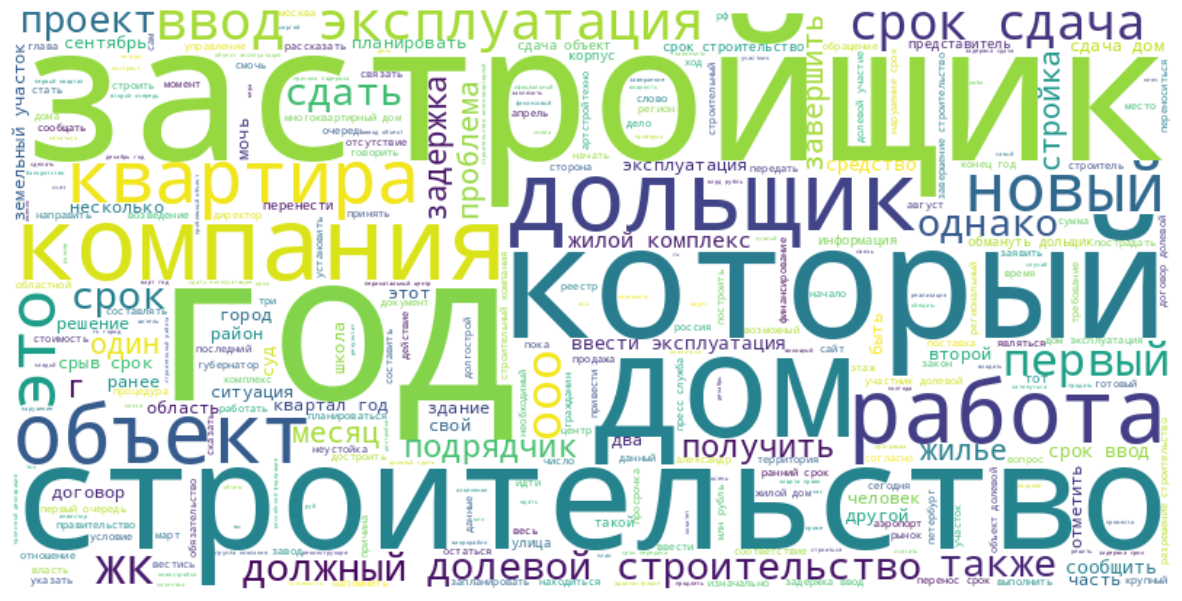

In [ ]:
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(train_texts)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:

preprocessed_test_texts = []

for text in tqdm(df_test.summary):
    preprocessed_test_texts.append(preprocessDataset(text))

In [ ]:
test_texts = ' '.join(preprocessed_test_texts)

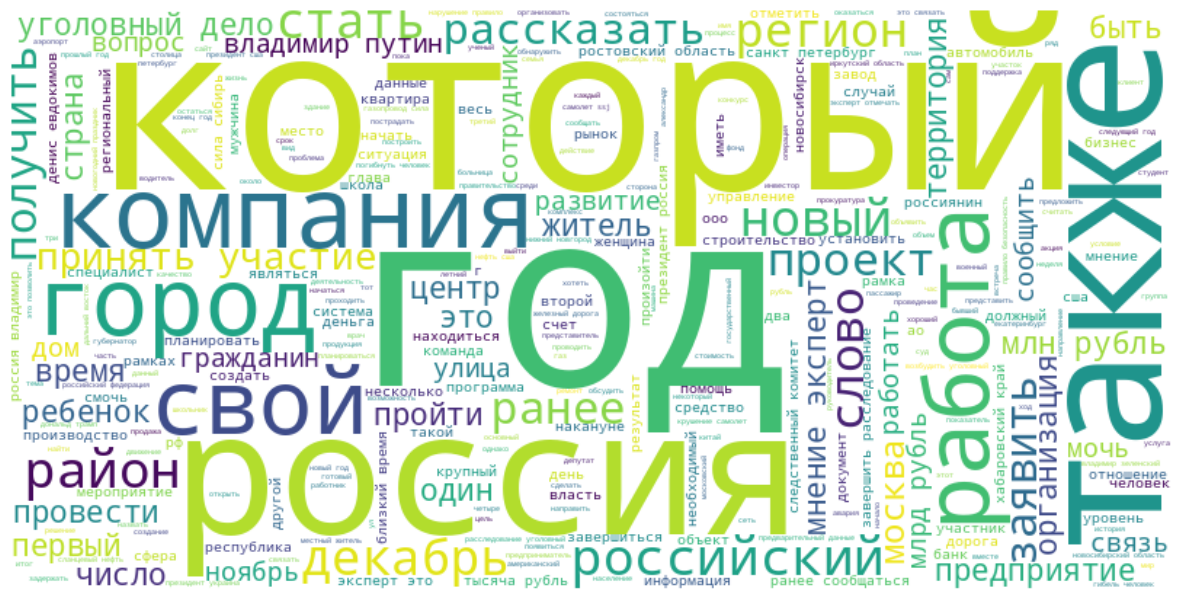

In [ ]:
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(test_texts)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

As you can see, there are not so many news articles about the delay in putting objects into operation in the test set. If there were more news articles with a positive label in the test set, it would be possible to add negative examples there

## Topic modeling

In [ ]:
from transformers import MBartTokenizer, MBartForConditionalGeneration
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
import torch

In [ ]:
classif_model = BertForSequenceClassification.from_pretrained('ai-forever/ruBert-base', num_labels=2, output_hidden_states=True)
classif_tokenizer = BertTokenizer.from_pretrained('ai-forever/ruBert-base', use_fast=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from eda.clustering import * 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

sentence_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
sentence_model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

In [ ]:
train_sentences_embbedings = get_bert_emb(df_train.sentence.values.tolist())

In [ ]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(3,16)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,16)),
    "random_state": 42
}

label_lower = 30
label_upper = 100
max_evals = 100


best_params_use, best_clusters_use, trials_use = bayesian_search(act_emb_arr,
                                                                 space=hspace,
                                                                 label_lower=label_lower,
                                                                 label_upper=label_upper,
                                                                 max_evals=max_evals)

In [ ]:
clusters = generate_clusters(train_sentences_embbedings,
                            n_neighbors = 15,
                            n_components = 3,
                            min_cluster_size = 7,
                            random_state = random_state)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
plot_clusters(sentences_embbedings, clusters, df_train.sentence.values.tolist())

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



Если график не отобразился:

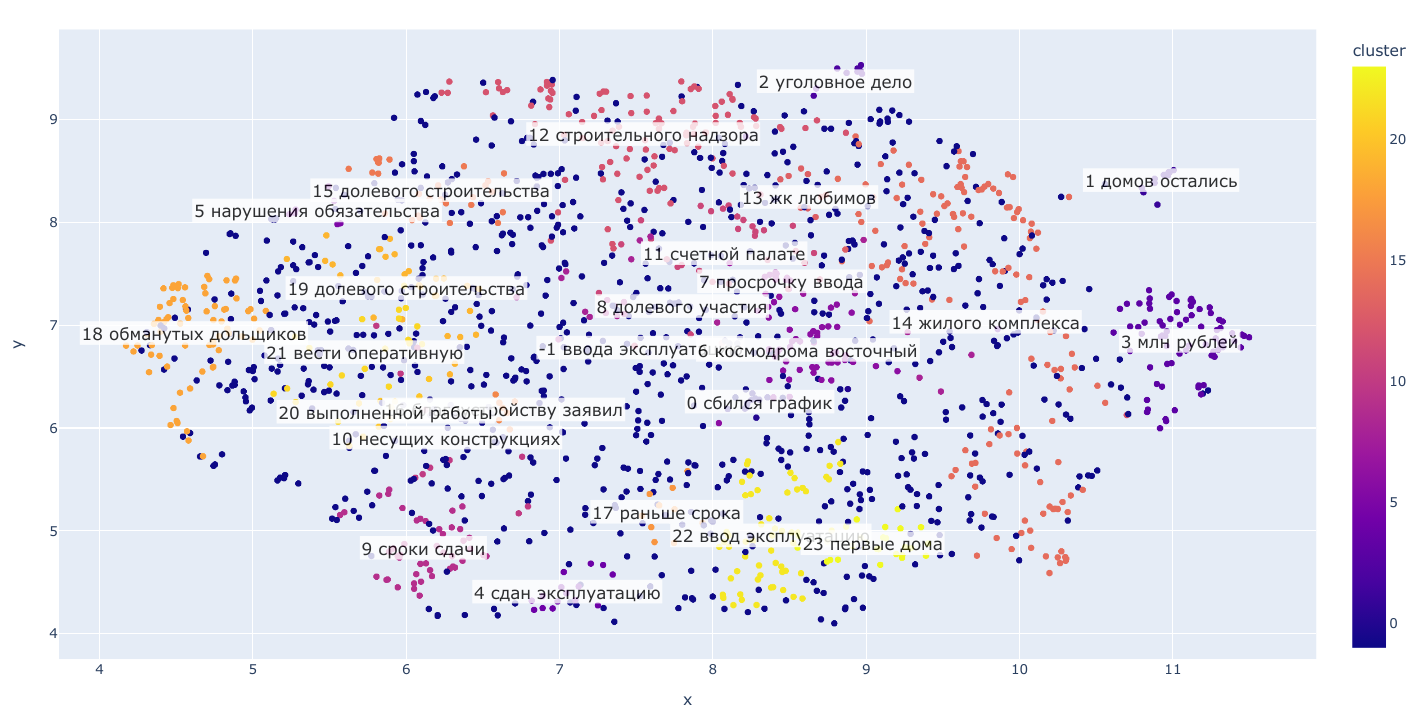

In [ ]:
test_sentences_embbedings = get_bert_emb(df_test_preprocessed.summary.values.tolist())

In [ ]:
space = {'n_neighbors': range(12, 16), 'n_components': range(3, 7), 'min_cluster_size': range(2, 16), 'random_state': random_state}
random_use = random_search(test_sentences_embbedings, space, 50)

In [ ]:
clusters = generate_clusters(test_sentences_embbedings,
                            n_neighbors = 30,
                            n_components = 10,
                            min_cluster_size = 30,
                            random_state = random_state)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
plot_clusters(test_sentences_embbedings, clusters, df_test_preprocessed.summary.values.tolist())

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



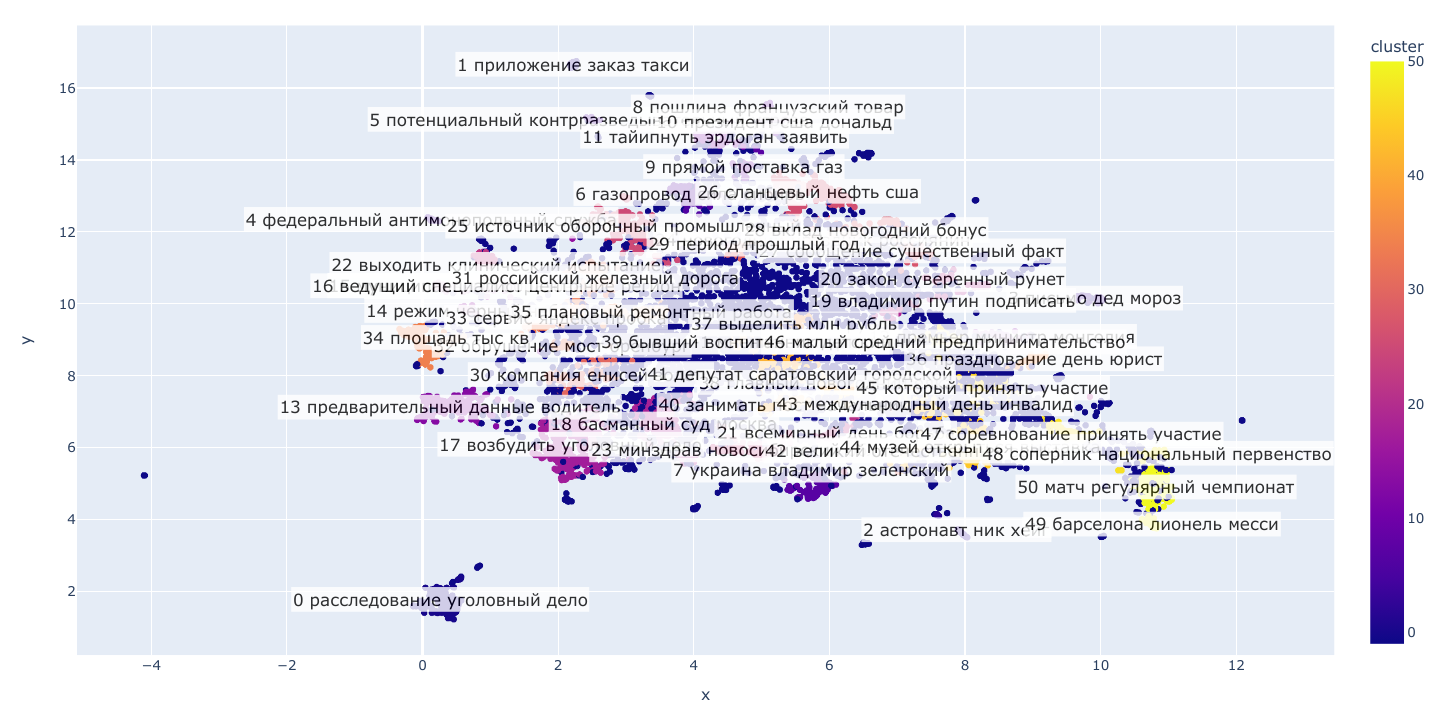

# Data split 

In [ ]:
from sklearn.model_selection import train_test_split
import os

set_seed()
test_size = 0.3
train_df, val_df = train_test_split(df_train, test_size=test_size, random_state = random_state, shuffle = True, stratify = df_train.label)

print("FULL Dataset: {}".format(df_train.shape))
print("TRAIN Dataset: {}".format(train_df.shape))
print("TEST Dataset: {}".format(val_df.shape))

print(df_train.label.mean(), train_df.label.mean(), val_df.label.mean())

FULL Dataset: (1612, 2)
TRAIN Dataset: (1128, 2)
TEST Dataset: (484, 2)
0.1935483870967742 0.19326241134751773 0.19421487603305784


# Classification

In [ ]:
from models.classificator import *

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classif_tokenizer = BertTokenizer.from_pretrained('ai-forever/ruBert-base', use_fast=False)
classif_model = BertForSequenceClassification.from_pretrained('ai-forever/ruBert-base', num_labels=2, output_hidden_states=False)
classif_model.to(device)

In [ ]:
set_seed()
train_dataset = dataset(train_df.reset_index(drop =True), classif_tokenizer, 512, True)
val_dataset = dataset(val_df.reset_index(drop =True), classif_tokenizer, 512, True)

In [ ]:
training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = 6,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    gradient_accumulation_steps  = 2,
    weight_decay =0.01,
    logging_dir = './logs',
    load_best_model_at_end = True,
    learning_rate = 1e-5,
    evaluation_strategy ='epoch',
    logging_strategy = 'epoch',
    save_strategy = 'epoch',
    save_total_limit = 1,
    seed=random_state)


In [ ]:
trainer = Trainer(model=classif_model,
                  tokenizer = classif_tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics = compute_metrics)

In [ ]:
# import torch, gc
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
trainer.train()

In [ ]:
model_path = "/content/drive/MyDrive/PROJECTS_COMPETITIONS/news_classification/fine-tune-bert"
classif_model.save_pretrained(model_path)
classif_tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/PROJECTS_COMPETITIONS/news_classification/fine-tune-bert/tokenizer_config.json',
 '/content/drive/MyDrive/PROJECTS_COMPETITIONS/news_classification/fine-tune-bert/special_tokens_map.json',
 '/content/drive/MyDrive/PROJECTS_COMPETITIONS/news_classification/fine-tune-bert/vocab.txt',
 '/content/drive/MyDrive/PROJECTS_COMPETITIONS/news_classification/fine-tune-bert/added_tokens.json')

# Model validation 

In addition to calculating metrics on the test set, ideally, it would be good to also inspect the top words triggered by our classifier at each activation layer. This way, we can understand if the model has overfit or not. Since this is a test task, and for the sake of memory and time efficiency, I loaded the model in a mode that does not return hidden layers, so I won't be doing this.

In [ ]:
def get_prediction(dataset, model):
    test_pred = model.predict(dataset)
    labels = np.argmax(test_pred.predictions, axis = -1)
    return labels
pred = get_prediction(val_dataset, trainer)

In [ ]:
classif_model.to(torch.device("cpu"))
trainer.model.to(torch.device("cpu"))

In [ ]:
model_path = "/content/drive/MyDrive/PROJECTS_COMPETITIONS/news_classification/fine-tune-bert"
pretr_tokenizer = BertTokenizer.from_pretrained(model_path, use_fast=True)
pretr_model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2, output_hidden_states=False)
pretr_model.to(device)

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True)

In [ ]:
def predict(data_loader, model):
    predictions = []
    probs = []
    pbar = tqdm(data_loader)
    for i, batch in enumerate(pbar, 1):
        with torch.no_grad():
            outputs = model(batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device))
            logits = outputs.logits
            prob = torch.nn.functional.softmax(logits, dim=1)[:, 1:].detach().cpu().numpy().flatten()
            logits = logits.detach().cpu().numpy()
            pred = np.argmax(logits, axis=1).flatten()

        predictions += list(pred)
        probs += list(prob)
    return predictions, probs

In [ ]:
val_predictions, val_probs = predict(val_loader, pretr_model)

100%|██████████| 61/61 [00:16<00:00,  3.66it/s]


In [ ]:
# метрики с предобработкой
print(classification_report(val_dataset.dataframe.label, val_predictions))
print(f1_score(val_dataset.dataframe.label, val_predictions))
print(accuracy_score(val_dataset.dataframe.label, val_predictions))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       390
           1       0.84      0.93      0.88        94

    accuracy                           0.95       484
   macro avg       0.91      0.94      0.92       484
weighted avg       0.95      0.95      0.95       484

0.8787878787878788
0.9504132231404959


In [ ]:
# метрики без нормальной предобработки данных
print(classification_report(val_dataset.dataframe.label, pred))
print(f1_score(val_dataset.dataframe.label, pred))
print(accuracy_score(val_dataset.dataframe.label, pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       402
           1       0.80      0.83      0.82        99

    accuracy                           0.93       501
   macro avg       0.88      0.89      0.88       501
weighted avg       0.93      0.93      0.93       501

0.8159203980099502
0.9261477045908184


# Test predictions 

In [ ]:
test_classif_loader = DataLoader(test_dataset(df_test, pretr_tokenizer, 512), batch_size=24, shuffle=False, pin_memory=True)

In [ ]:
test_predictions, test_probs = predict(test_classif_loader, pretr_model)

100%|██████████| 441/441 [06:27<00:00,  1.14it/s]


In [ ]:
# как видно, новостей про события, о задержке ввода объекта в эксплуатацию очень мало
np.array(test_predictions).mean()

0.010311228833601362

In [ ]:
df_test['probs'] = np.array(test_probs)

In [ ]:
df_test[['id', 'title', 'text', 'probs']].to_csv('/content/drive/MyDrive/PROJECTS_COMPETITIONS/news_classification/test_data.csv')